In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import seaborn as sns
customer_info = pd.read_csv('customer_info.csv')
customer_basket = pd.read_csv('customer_basket.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'customer_info.csv'

In [9]:
customer_basket

,invoice_id,list_of_goods,customer_id
0,5062209,"['megaman zero 3', 'energy bar', 'pokemon viol...",4925
1,4272512,"['black beer', 'bramble', 'laptop', 'pokemon v...",19046
2,7121052,"['soup', 'shallot', 'cake', 'fresh bread', 'cr...",10318
3,5847748,"['soup', 'cooking oil', 'cereals', 'oil', 'dog...",27283
4,6336114,"['eggplant', 'mint green tea', 'oil', 'bacon',...",16072
...,...,...,...
99995,5389466,"['frozen smoothie', 'avocado', 'dog food', 'ch...",26170
99996,10387390,"['cake', 'antioxydant juice', 'honey', 'toothp...",19691
99997,7103407,"['candy bars', 'spaghetti', 'oil', 'final fant...",1720
99998,4093515,"['shallot', 'cereals', 'oil', 'deodorant', 'me...",24989


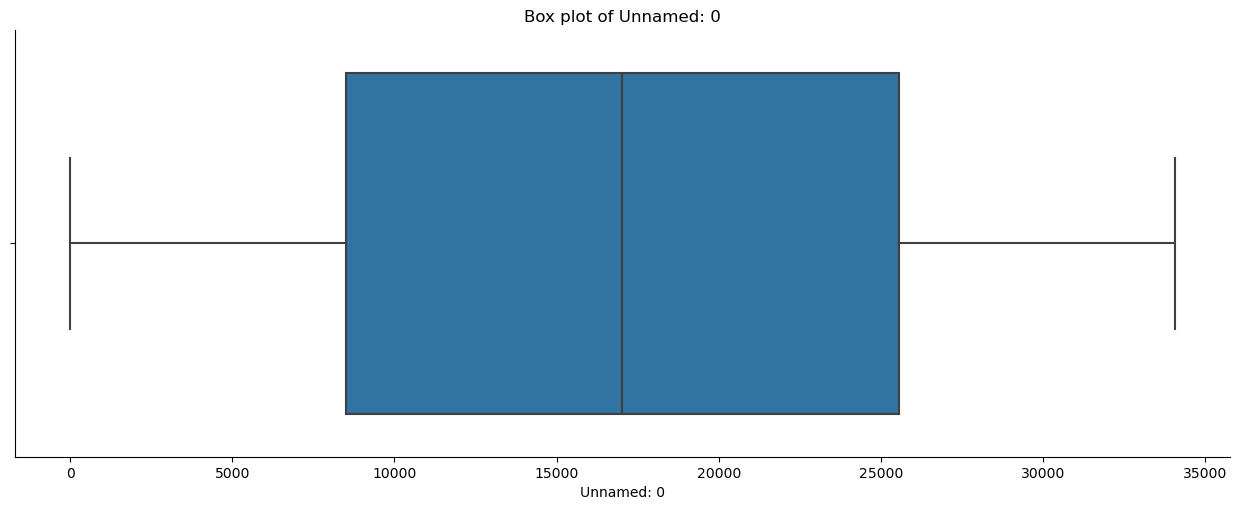

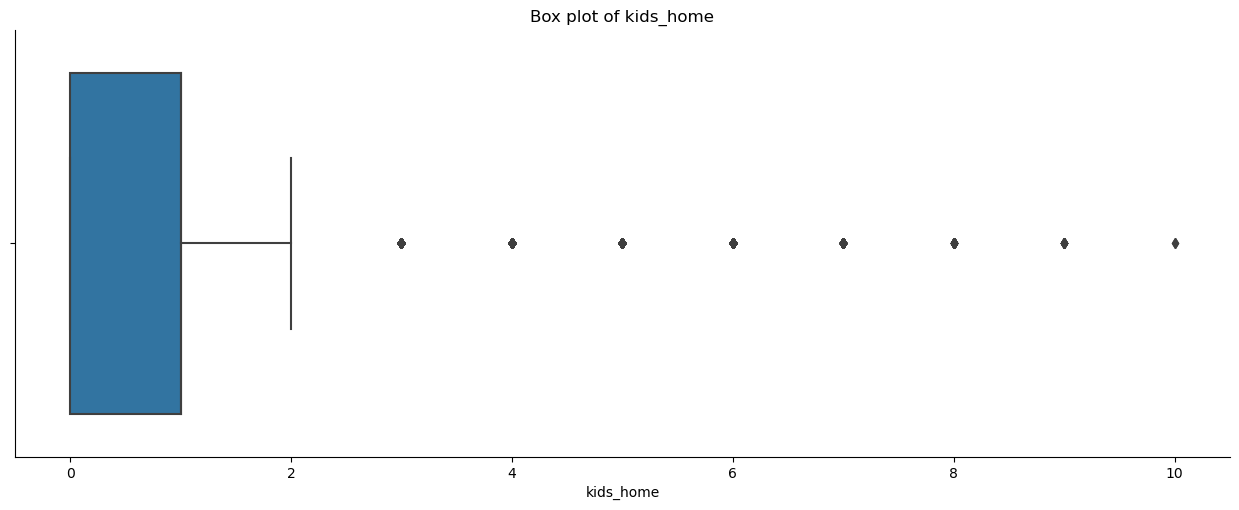

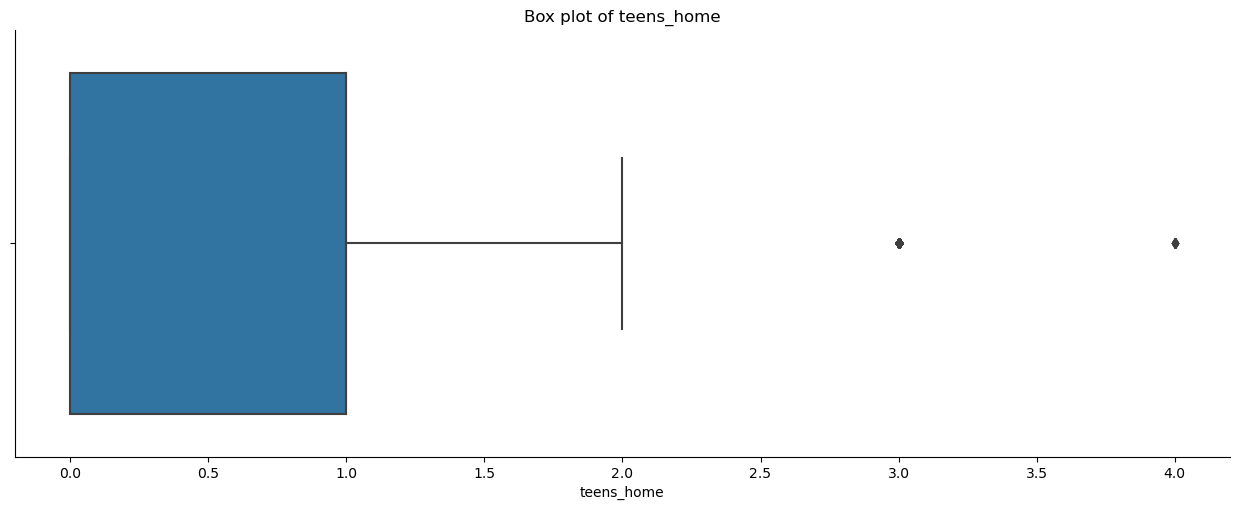

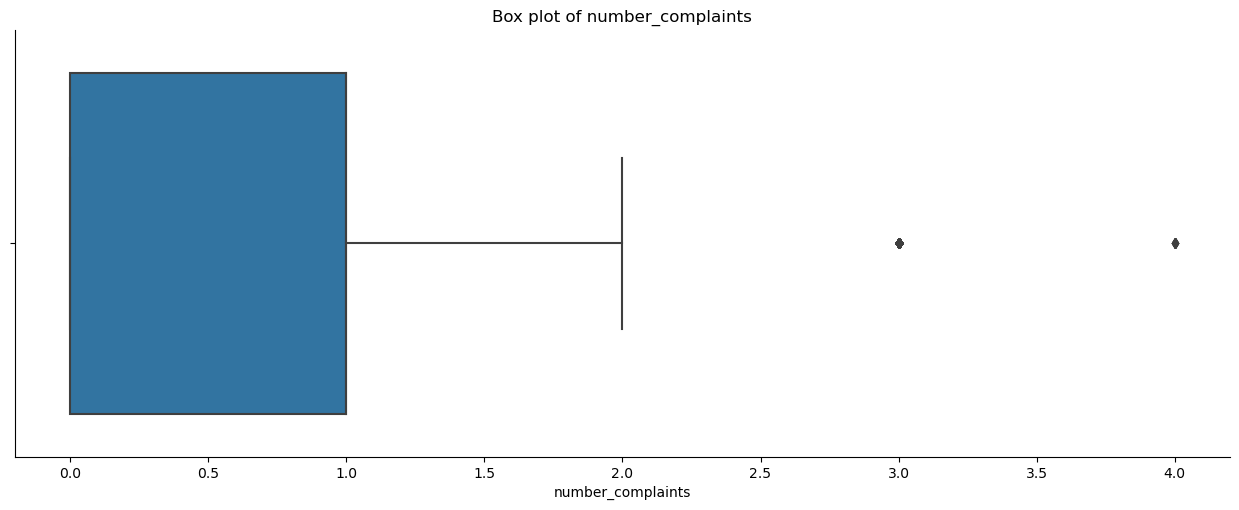

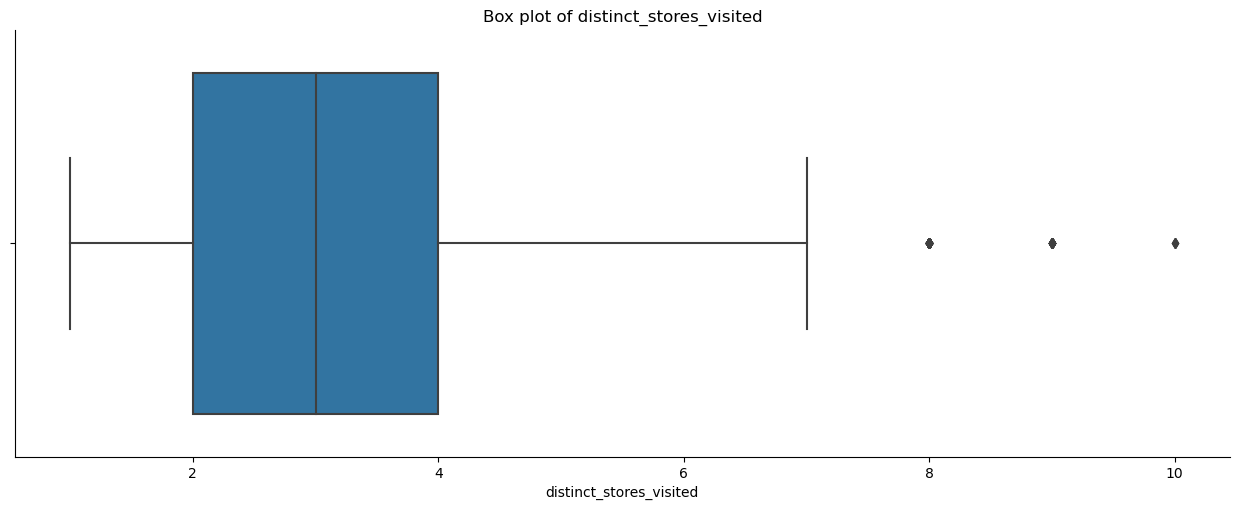

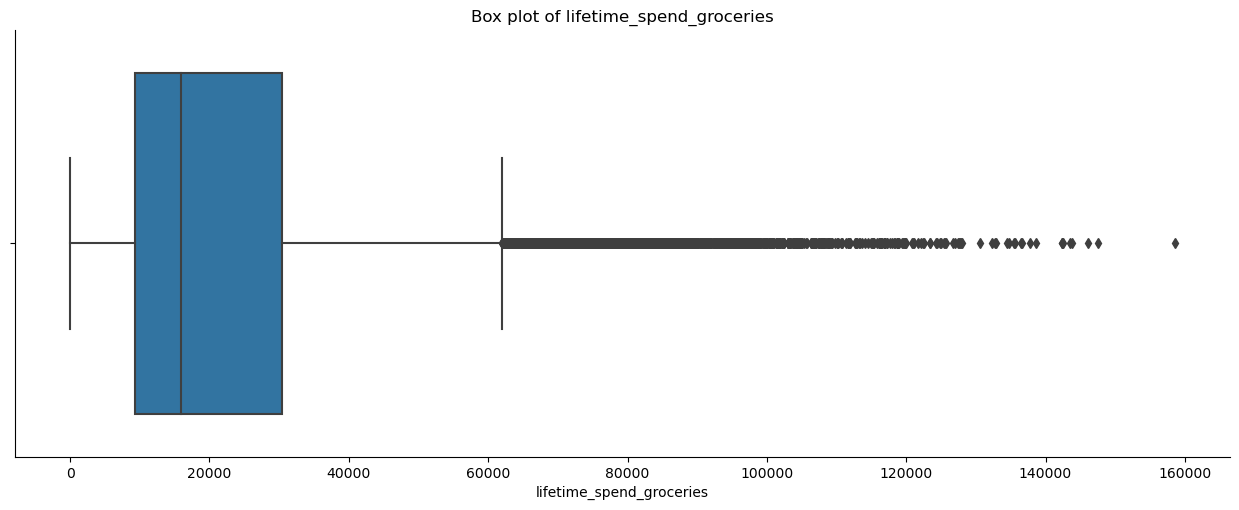

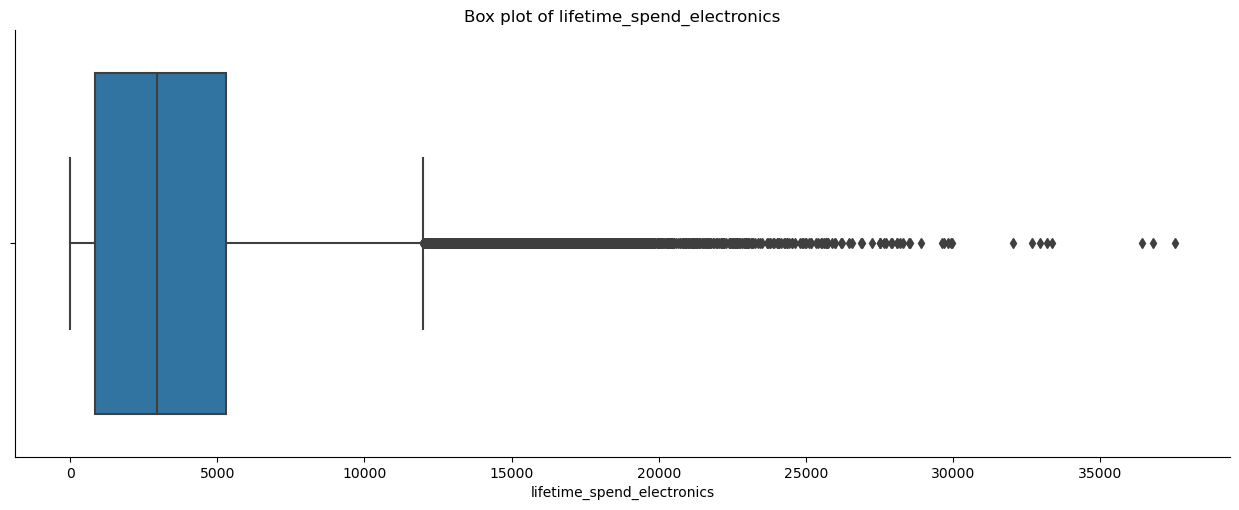

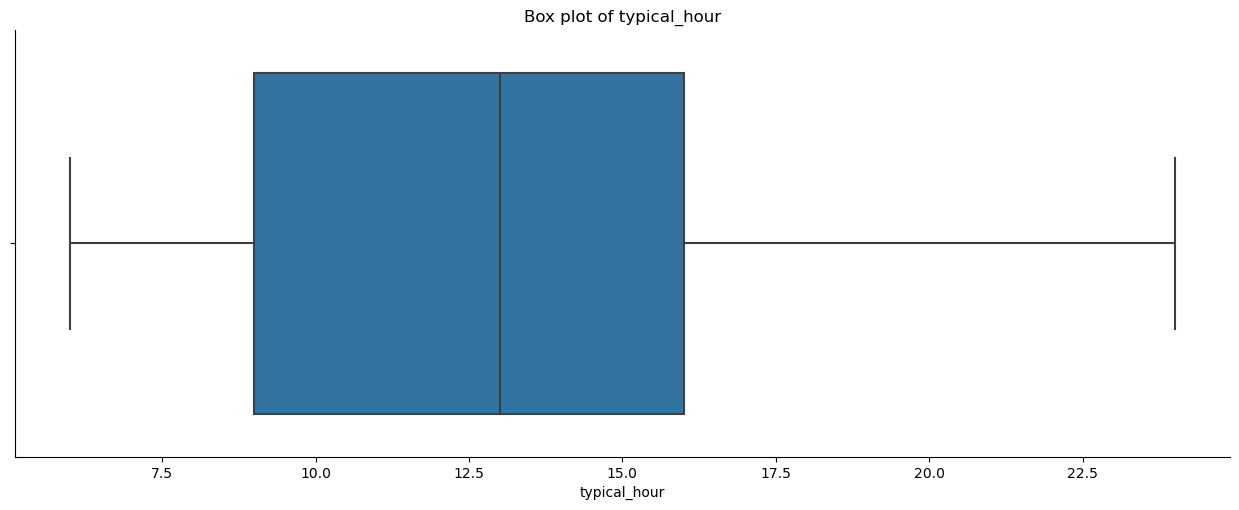

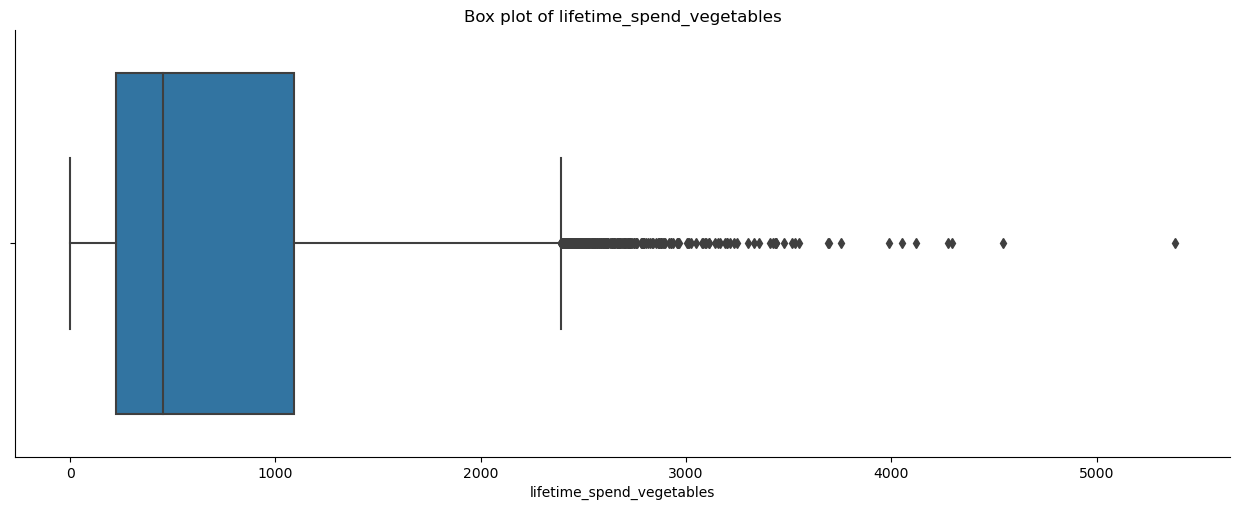

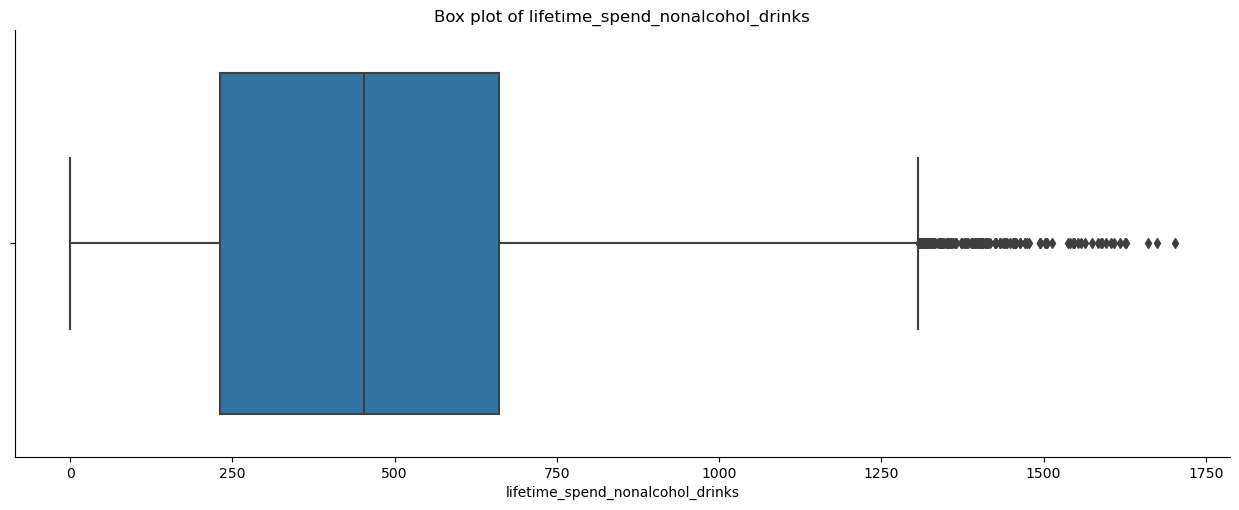

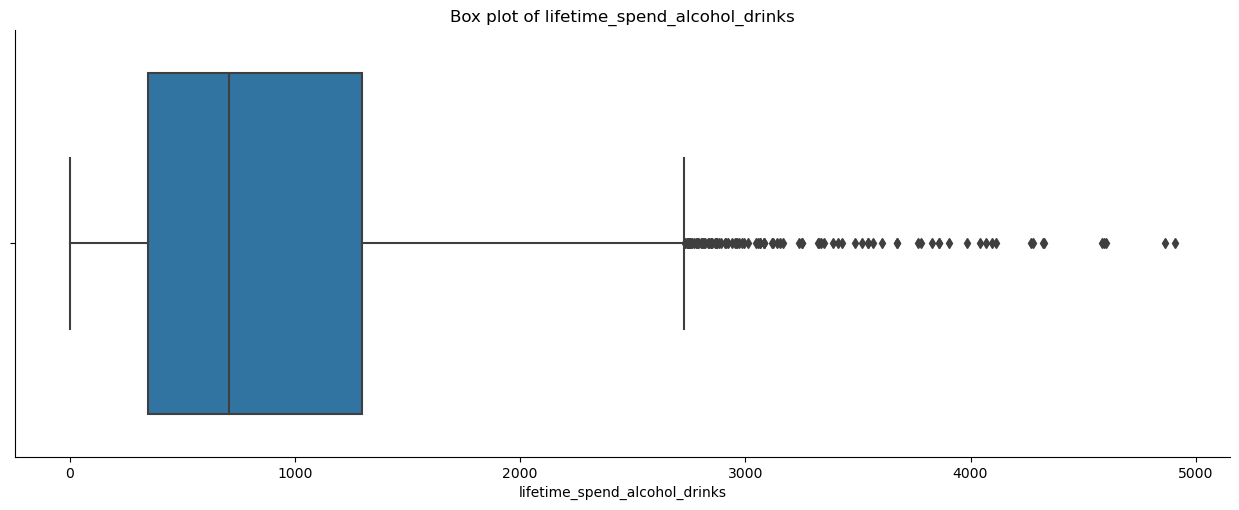

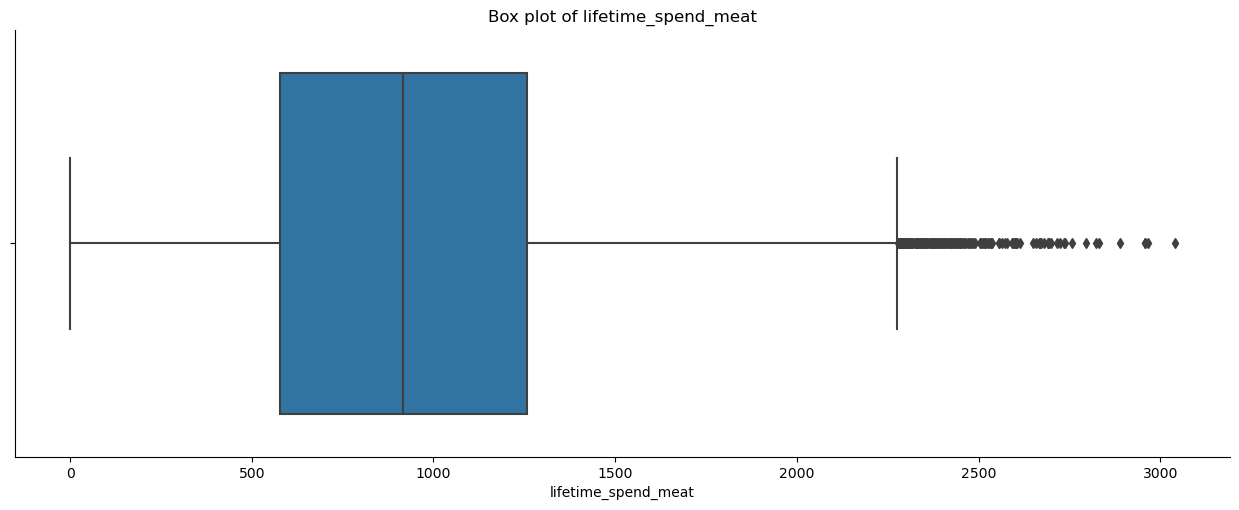

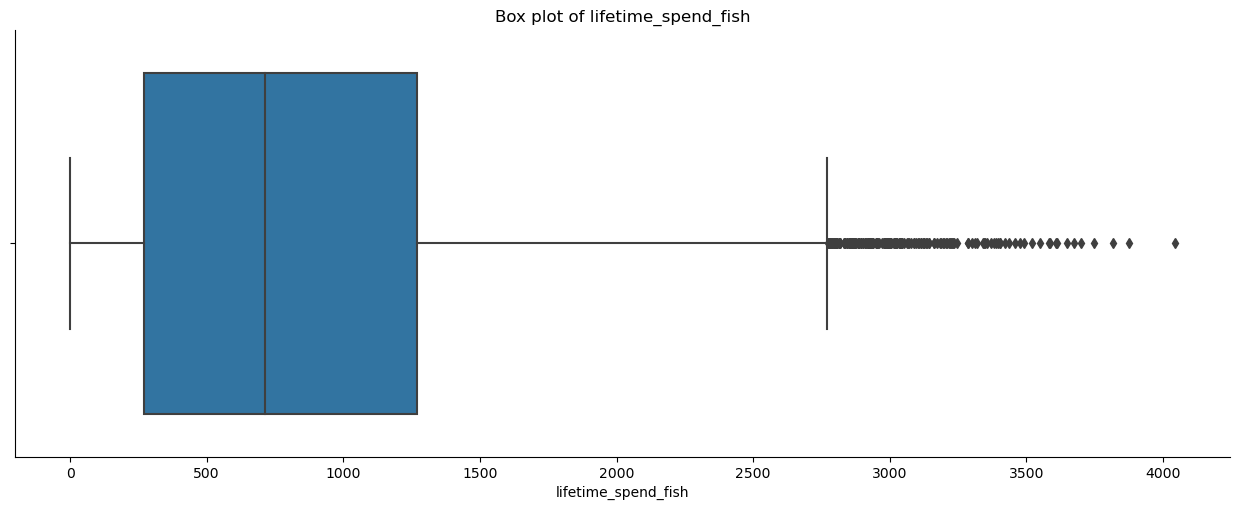

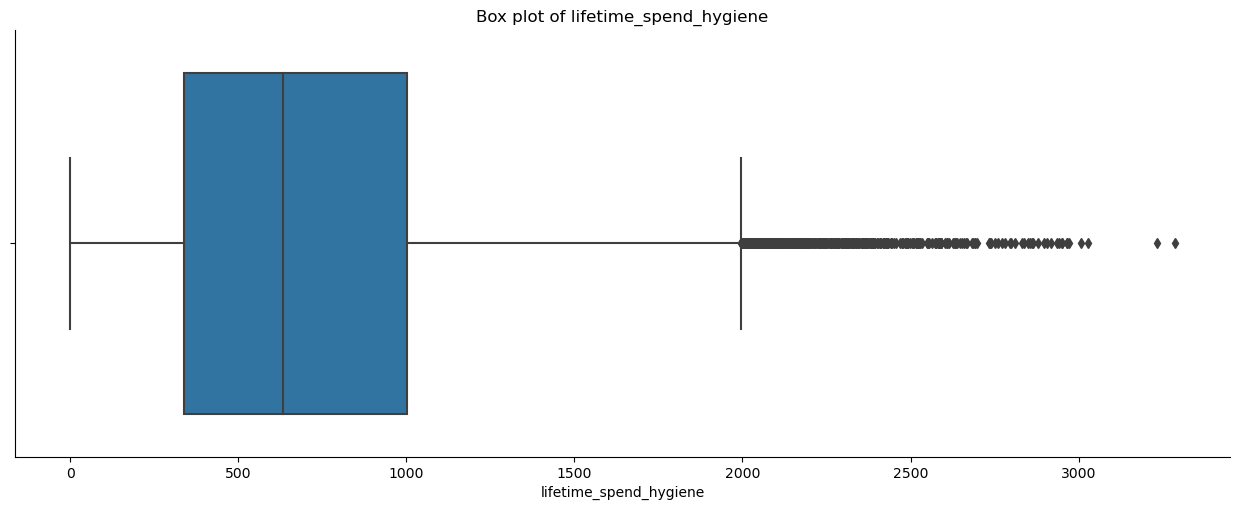

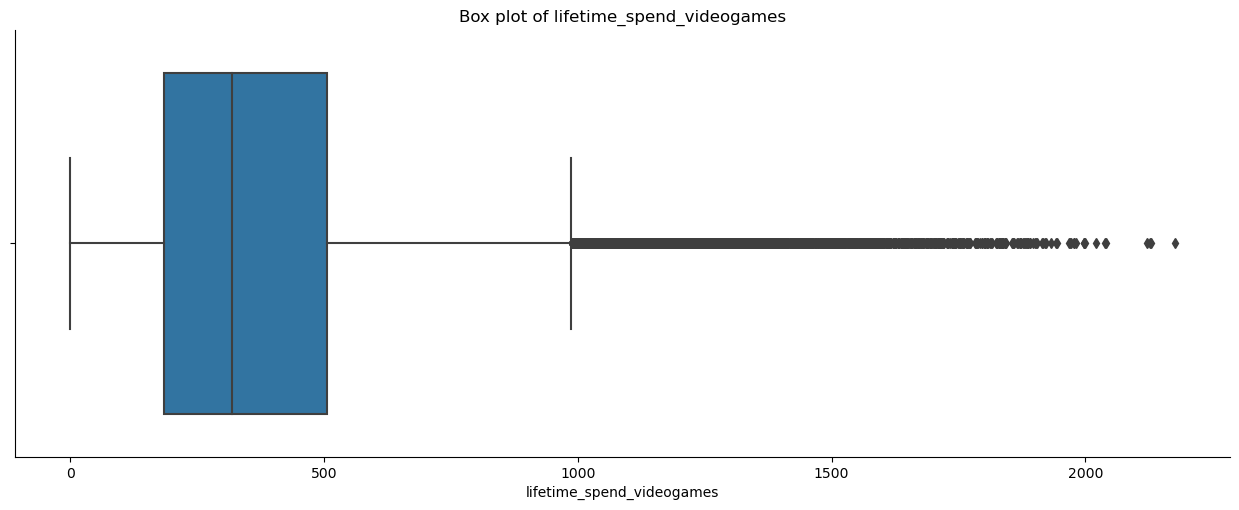

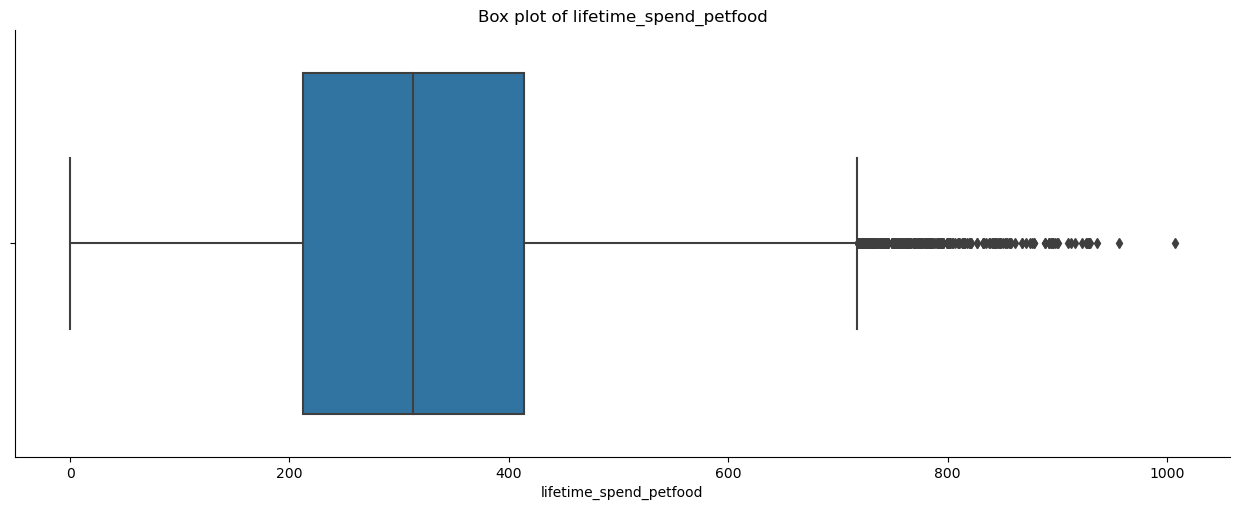

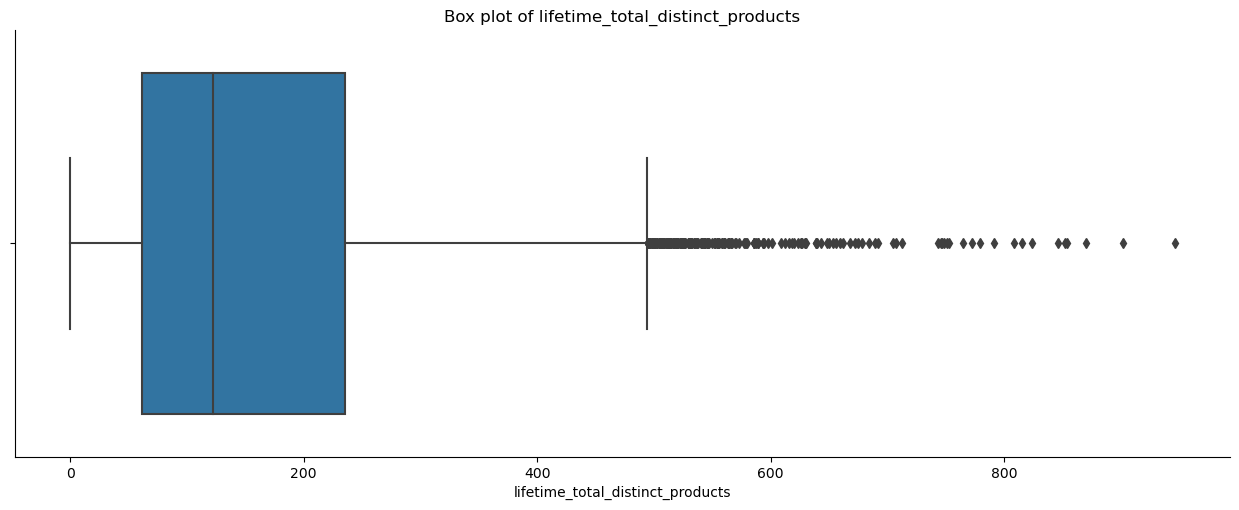

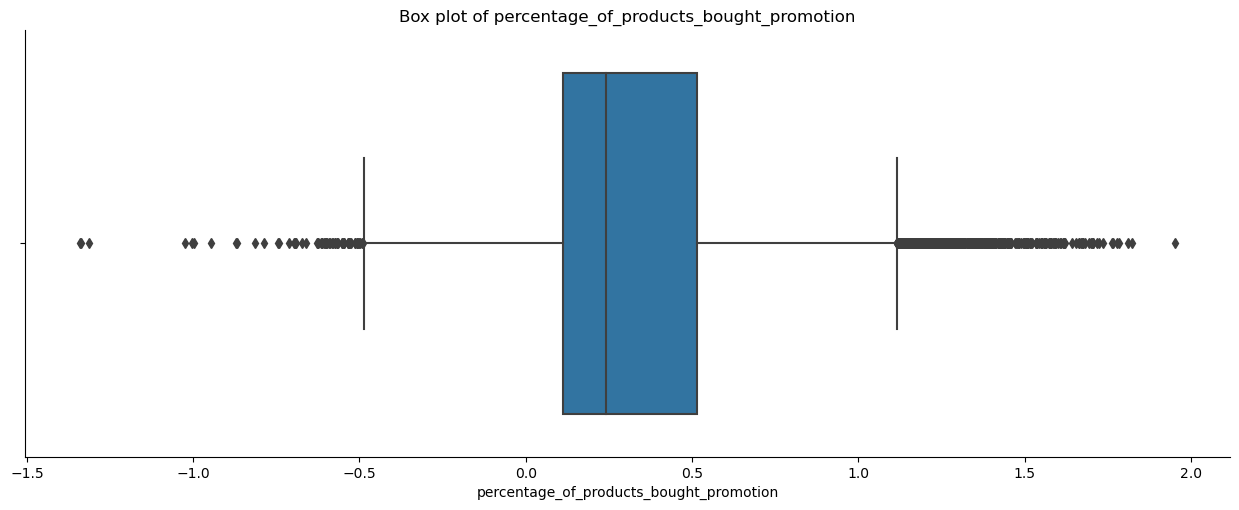

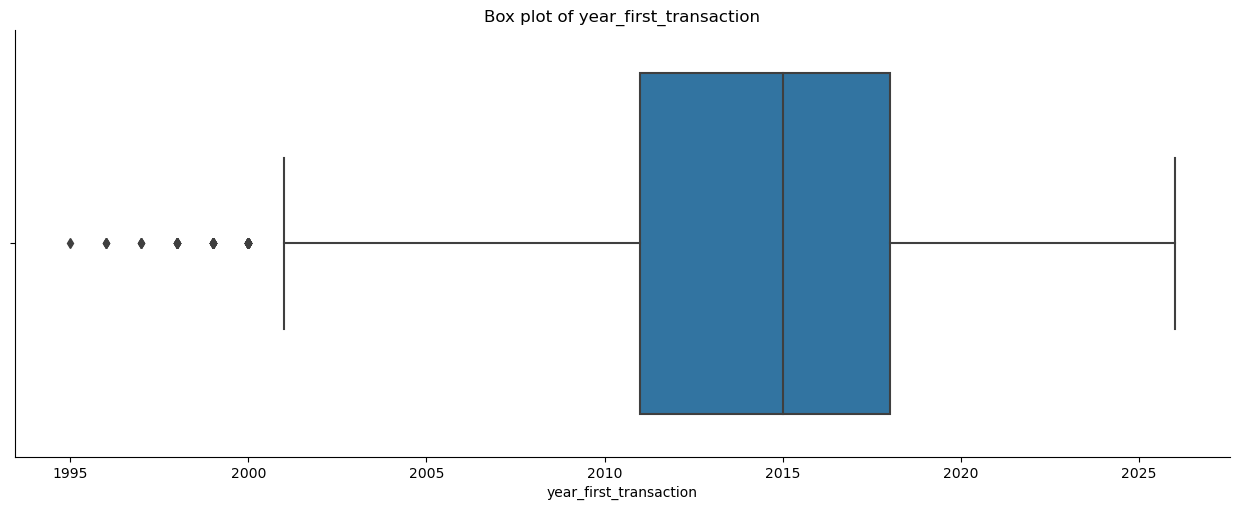

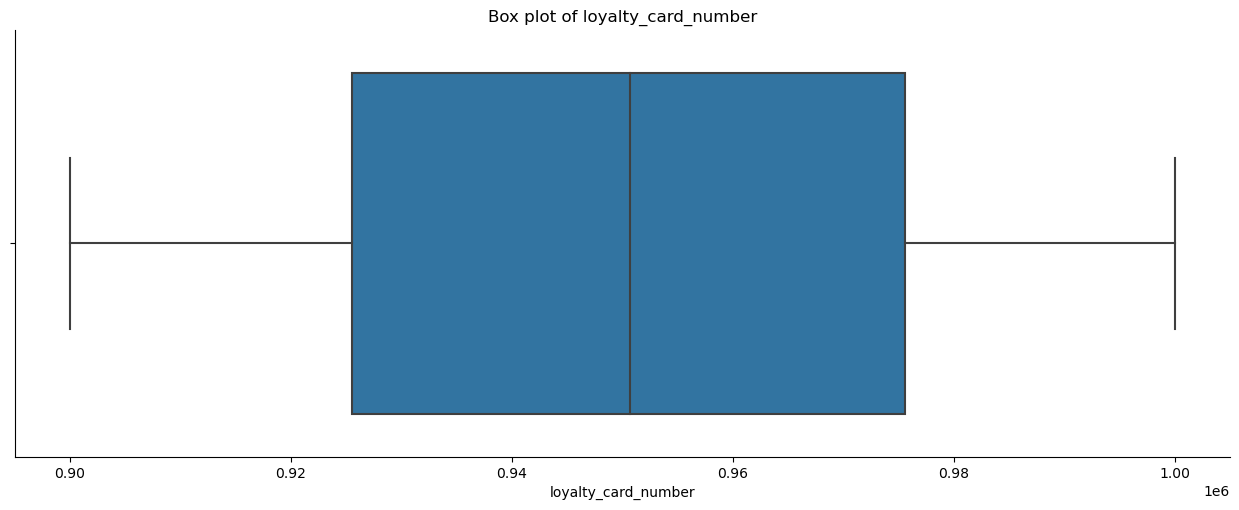

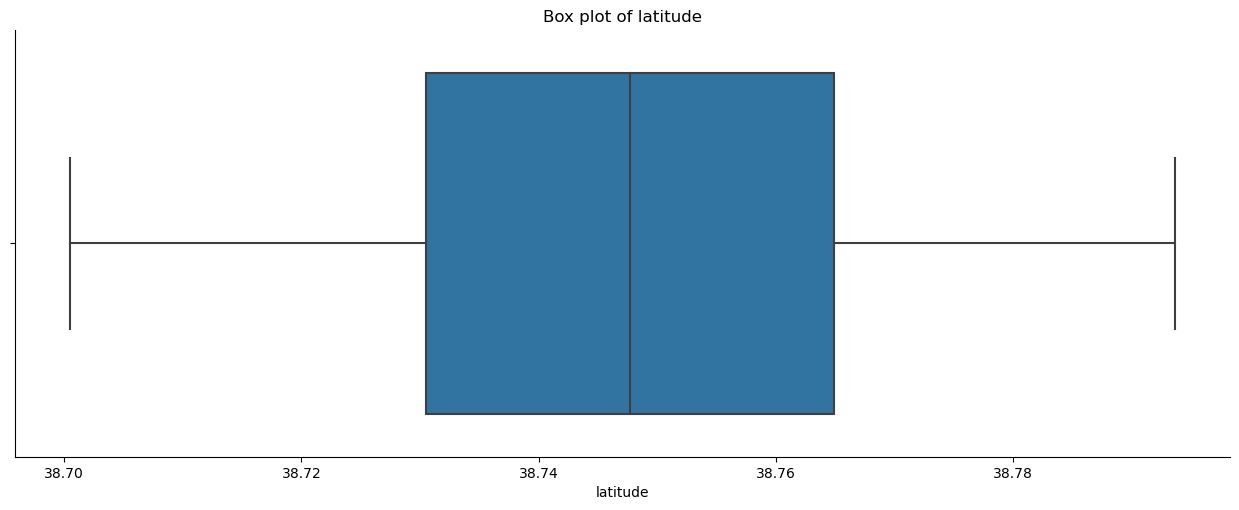

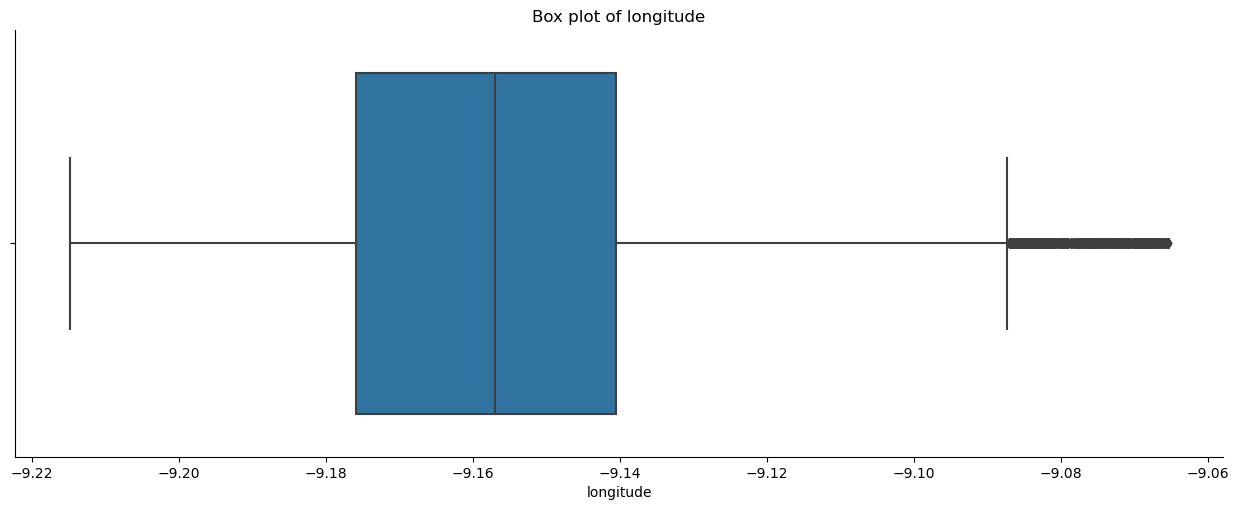

In [8]:
for var in customer_info.describe().columns.drop(['customer_id']):
    sns.catplot(data=customer_info, x=var, kind='box', height=5, aspect=2.5)
    plt.title(f'Box plot of {var}')
    plt.show()
